In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import bootstrap

# Giannoulis, this is a test

            Timestamp      Wsp      TI  TI,detrend   MeanDir  MeanTrigDir  \
0 2004-10-01 00:00:00   9.9196  0.0181      0.0145  346.7130     346.7130   
1 2004-10-01 00:20:00   9.5073  0.0145      0.0116  346.9852     346.9852   
2 2004-10-01 00:30:00   9.5274  0.0210      0.0195  346.9152     346.9151   
3 2004-10-01 00:40:00   9.9498  0.0253      0.0195  346.3204     346.3204   
4 2004-10-01 00:50:00  10.2376  0.0151      0.0134  345.4185     345.4185   

   StdDir   MinDir   MaxDir  
0  0.8440  343.893  349.044  
1  0.6518  344.751  348.949  
2  0.7949  343.754  350.588  
3  0.7549  343.971  349.953  
4  0.6362  343.074  348.960  


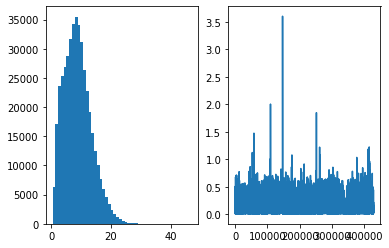

In [3]:
data_path = '../data/'
results_path = '../results/'

# load and print dataset
raw_data = pd.read_csv(data_path + 'HovsoreData_Sonic_100m_2004-2013.csv')
raw_data.head()
raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'], format='%Y%m%d%H%M')

filt_idx = ((raw_data["Wsp"] > 60) | (raw_data["Wsp"] < 0.05)) | ((raw_data["TI"] < 0.01) | (raw_data["TI"] > 4))
filtered_data = raw_data[~filt_idx]
filtered_data = filtered_data.dropna(axis=0)
filtered_data = filtered_data.reset_index(drop=True)
print(filtered_data.head(5))

# visualise dataset
# plt.plot(raw_data['Wsp'])
fig, ax = plt.subplots(1,2)
# ax[0].hist(raw_data["Wsp"][raw_data["Wsp"] < 60], 50)
# ax[1].plot(raw_data["TI"]) # outliers can be observed
ax[0].hist(filtered_data["Wsp"], 50)
ax[1].plot(filtered_data["TI"]) # outliers can be observed

plt.show()

# Fit joint distribution to wind speed, turbulence

In [4]:
# compute turbulence from sigmaU = TI * Wsp
filtered_data['sigmaWsp'] = filtered_data["TI"] * filtered_data["Wsp"]
filtered_data.head(3)

# fit weibull to wind speed : maximum likelihood method
Wsp0 = np.asarray(filtered_data["Wsp"])
# Wsp0 = Wsp0[Wsp0 < 60]
print(sum(np.isnan(Wsp0)))

mle_Weib = lambda theta : -np.sum(np.log( stats.weibull_min.pdf(Wsp0, loc=0, scale=theta[0], c=theta[1]) ))
Weibull_params = scipy.optimize.minimize(mle_Weib, [Wsp0.mean(), np.log(Wsp0).std()])
print(Weibull_params)
A_weibull = Weibull_params.x[0]
k_weibull = Weibull_params.x[1]

print("\nWeibull distribution:")
print(f"A:{A_weibull}")
print(f"k:{k_weibull}")

# fitted weibull distribution
Wsp_sort = np.sort(Wsp0)
pdf_weibull = stats.weibull_min.pdf(Wsp_sort, scale=A_weibull, c=k_weibull)

0
      fun: 1239279.5737238429
 hess_inv: array([[ 1.66014077e-04, -1.97192206e-05],
       [-1.97192206e-05,  8.73166638e-06]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 10
     njev: 15
   status: 0
  success: True
        x: array([9.98342566, 2.03255618])

Weibull distribution:
A:9.983425656103979
k:2.0325561802935543


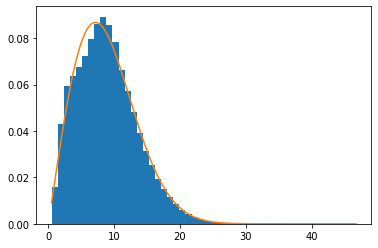

In [5]:
# Visualise fitted distribution
fig, ax = plt.subplots(1)
ax.hist(Wsp0, bins=50, density=True)
ax.plot(Wsp_sort, pdf_weibull)
plt.show()

In [6]:
# Fit conditional distribution to turbulence - bin data
WspBinEdges = np.arange(3.5, 32.5, 1)
WspBinCentres = .5 + WspBinEdges[:-1]

# initialise mean and std of turbulence for each bin
meanSigmaBinned = np.zeros_like(WspBinCentres)
stdSigmaBinned = np.zeros_like(WspBinCentres)

# find mean and std of turbulence (=sigmaU) in each bin
for i,val in enumerate(WspBinCentres):
    WspMask = (filtered_data["Wsp"] > WspBinEdges[i]) & (filtered_data["Wsp"] <= WspBinEdges[i+1])
    meanSigmaBinned[i] = np.mean( filtered_data.loc[WspMask, "sigmaWsp"] )
    stdSigmaBinned[i] = np.std( filtered_data.loc[WspMask, "sigmaWsp"] )
    
meanSigmaBinned = meanSigmaBinned[~np.isnan(meanSigmaBinned)]   
stdSigmaBinned = stdSigmaBinned[~np.isnan(meanSigmaBinned)]   
# print(len(WspBinEdges))
# print(enumerate(WspBinCentres))
# print(len(meanSigmaBinned))
# print(len(meanSigmaBinned))

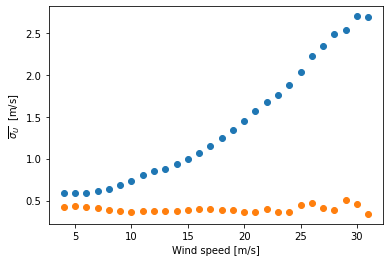

In [7]:
plt.scatter(WspBinCentres, meanSigmaBinned)
plt.scatter(WspBinCentres, stdSigmaBinned)
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r"$\overline{\sigma_U}$  [m/s]")
plt.show()

In [8]:
pMu0 = np.polyfit(WspBinCentres, meanSigmaBinned,0)
pMu1 = np.polyfit(WspBinCentres, meanSigmaBinned,1)
pMu2 = np.polyfit(WspBinCentres, meanSigmaBinned,2)
pMsu0 = np.polyfit(WspBinCentres, stdSigmaBinned,0)

poly0 = np.poly1d(pMu0)
poly1 = np.poly1d(pMu1)
poly2 = np.poly1d(pMu2)
poly3 = np.poly1d(pMsu0)

SigmaSigmaRef = np.mean(stdSigmaBinned)
        
MuSigmaFunc = lambda u: poly2(u)
SigmaSigmaFunc = lambda u: SigmaSigmaRef * np.ones(u.shape)


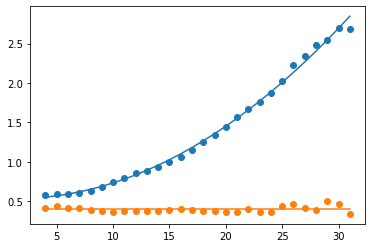

In [9]:
plt.scatter(WspBinCentres, meanSigmaBinned)
plt.scatter(WspBinCentres, stdSigmaBinned)
# plt.plot(WspBinCentres, poly0(WspBinCentres))
# plt.plot(WspBinCentres, poly1(WspBinCentres))
plt.plot(WspBinCentres, poly2(WspBinCentres))
plt.plot(WspBinCentres, poly3(WspBinCentres))
plt.show()

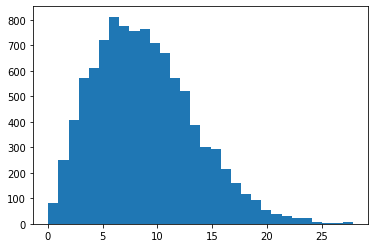

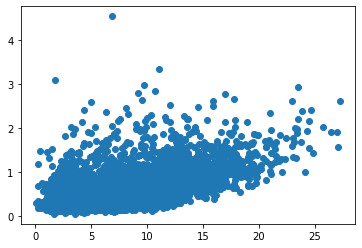

In [10]:
# Monte Carlo 
n = 10000

# Wind speed random sample
Urand = stats.weibull_min.ppf(np.random.randn(n), scale=A_weibull, c=k_weibull)
Urand = stats.weibull_min.rvs(scale=A_weibull, c=k_weibull, size=n)

# Turbulence random sample
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y
# Helper function - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    tol = 1e-16
    mu = np.asarray(mu)
    mu[mu<tol] = tol
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

MuSigmaU = MuSigmaFunc(Urand)
SigmaSigmaU = SigmaSigmaFunc(Urand)
SigmaUrand = LogNormDist(2, np.random.randn(n), mu=MuSigmaU, sigma=SigmaSigmaU)
# SigmaSigmaUrand = stats.lognorm.ppf(np.random.randn(n), s=SigmaSigmaU)

plt.hist(Urand, 30)
plt.show()
plt.scatter(Urand, SigmaUrand)
plt.show()

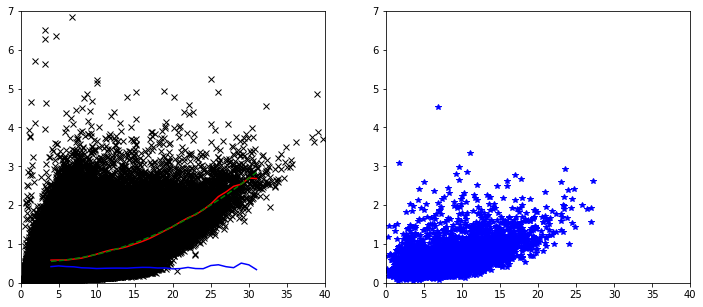

In [11]:
fig,ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(filtered_data['Wsp'],filtered_data['sigmaWsp'],'xk')
ax[0].plot(WspBinCentres,meanSigmaBinned,'-r')
ax[0].plot(WspBinCentres,stdSigmaBinned,'-b')
ax[0].plot(WspBinCentres,MuSigmaFunc(WspBinCentres),'--g')
ax[0].set_xlim([0,40])
ax[0].set_ylim([0,7])
ax[1].plot(Urand,SigmaUrand,'*b')
ax[1].set_xlim([0,40])
ax[1].set_ylim([0,7])
plt.show()

# Task 2

In [12]:
def print_loading_bar(iteration, total, bar_length=100):
    progress = (iteration / total)
    arrow = '=' * int(round(progress * bar_length) - 1)
    spaces = ' ' * (bar_length - len(arrow))

    print(f'\r[{arrow + spaces}] {progress * 100:.0f}%', end='')

In [13]:
# # Confidence intervals based on Bootstrapping

# yearss = pd.unique(filtered_data['Timestamp'].dt.year.values)
# # yearss = [2004]

# print(yearss)

# alpha = 1-0.98

# BootstrapMeans_stacked = np.zeros(1)
# Boooooo = np.zeros_like(yearss)

# M = 1000

# for iyear,year in enumerate(yearss): 
    
# #     maybe metavlito M (see this tomorrow)
    
#     boot2004 = filtered_data[filtered_data['Timestamp'].dt.year == year]
    
#     M = len(boot2004)
# #     print(year, len(boot2004))
#     l = 5000
    
# #     l = 1000
# #     print(l)
    
#     BootstrapSample = np.random.choice(boot2004['Wsp'], size = (l, M))
# #     BootstrapMeans_temp = np.sort(np.mean(BootstrapSample, axis=1))
#     BootstrapMeans_temp = np.mean(BootstrapSample, axis=1)
# #     print(len(BootstrapMeans_temp))
#     # stack the BootstrapMeans_temp of each year vertically  
#     # BootstrapMeans = np.sort(np.mean(BootstrapSample, axis=1))
#     BootstrapMeans_stacked = np.concatenate((BootstrapMeans_stacked, BootstrapMeans_temp), axis=None)
#     Boooooo[iyear] = np.mean(BootstrapMeans_temp)
#     print_loading_bar(iyear+1,len(yearss))
    

# print()
# print(Boooooo)
# # resort data
# BootstrapMeans = np.sort(BootstrapMeans_stacked[1:])
# print(np.mean(BootstrapMeans), len(BootstrapMeans))
# len_bs = len(BootstrapMeans)

# # Determine confidence intervals
# Rlow = int(np.around((len_bs+1)*alpha/2))
# Rhigh = int(np.around((1-alpha/2)*(len_bs+1)))
# print(Rlow, Rhigh)

# CIn_B = BootstrapMeans[Rlow]
# CIp_B = BootstrapMeans[Rhigh]

# print('Confidence interval based on bootstrapping: [' + str(CIn_B) + ', ' + str(CIp_B) + ']')


In [14]:
yearss = pd.unique(filtered_data['Timestamp'].dt.year.values)

print(yearss)

alpha = 1-0.95

BootstrapMeans_stacked = np.zeros(1)
Boooooo = np.zeros(yearss.shape)

for iyear,year in enumerate(yearss): 
        
    boot2004 = filtered_data[filtered_data['Timestamp'].dt.year == year]
    wsp_mean_temp = boot2004['Wsp'].mean()
    print(wsp_mean_temp)
    print(iyear)
    Boooooo[iyear] = wsp_mean_temp
    

print()
print(Boooooo)

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
10.081660743420043
0
8.787261217223874
1
8.417612116558418
2
9.502974268871307
3
9.146611058790489
4
8.502559819742608
5
8.288662736326721
6
9.33905285693346
7
9.121512028379277
8
7.6420449895011435
9

[10.08166074  8.78726122  8.41761212  9.50297427  9.14661106  8.50255982
  8.28866274  9.33905286  9.12151203  7.64204499]


In [15]:
Nbootstrap = 100000
BootstrapSize = len(Boooooo) # 8

BootstrapSample = np.random.choice(Boooooo, size = (Nbootstrap,BootstrapSize))

BootstrapMeans = np.sort(np.mean(BootstrapSample, axis=1))

Rlow = int(np.around(alpha/2*(Nbootstrap+1)))
Rhigh = int(np.around((1-alpha/2)*(Nbootstrap+1)))

print(Rlow,Rhigh)
CIn_B = BootstrapMeans[Rlow]
CIp_B = BootstrapMeans[Rhigh]

print('Confidence interval based on bootstrapping: [' + str(CIn_B) + ', ' + str(CIp_B) + ']')
print(CIp_B-CIn_B)

2500 97501
Confidence interval based on bootstrapping: [8.470070249985714, 9.296400894932088]
0.8263306449463741


In [16]:
# from scipy.stats import norm

# dist = norm(loc=2, scale=4)  # our "unknown" distribution
# rng = np.random.default_rng()
# data = dist.rvs(size=100, random_state=rng)
# data = filtered_data['Wsp'][::50].values
# print(data)
# mean_sample = np.mean(data)
# res = bootstrap((data,), np.mean, confidence_level=0.98,
#                 random_state=rng)
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=25)
# ax.set_title('Bootstrap Distribution')
# ax.set_xlabel('statistic value')
# ax.set_ylabel('frequency')
# plt.show()

# x = np.linspace(5, 10, 1000)
# pdf = norm.pdf(x, loc=mean_sample, scale=res.standard_error)
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=50, density=True)
# ax.plot(x, pdf)
# ax.set_title('Normal Approximation of the Bootstrap Distribution')
# ax.set_xlim(8.6,9)
# ax.set_xlabel('statistic value')
# ax.set_ylabel('pdf')
# plt.show()

In [17]:
n = len(Boooooo)

# print(yearss)
# print(len(filtered_data['Wsp'][filtered_data['Timestamp'].dt.year.isin(yearss)]))
Umean = np.mean(filtered_data['Wsp'][filtered_data['Timestamp'].dt.year.isin(yearss)])
Ustd = np.std(filtered_data['Wsp'][filtered_data['Timestamp'].dt.year.isin(yearss)])
Umean = np.mean(Boooooo)
Ustd = np.std(Boooooo)
print(Umean)
# print(len(filtered_data['Wsp'][filtered_data['Timestamp'].dt.year == year]))
# print(len(boot2004))


8.882995183574733


In [18]:
# Confidence intervals based on the Normal distribution

CIn_N = Umean + stats.norm.ppf(alpha/2) * Ustd / np.sqrt(n)
CIp_N = Umean + stats.norm.ppf(1 - alpha/2) * Ustd / np.sqrt(n)

print('Confidence interval based on the Normal distribution: [' + str(CIn_N) + ', ' + str(CIp_N) + ']')

Confidence interval based on the Normal distribution: [8.470973117983942, 9.295017249165525]


In [19]:
# Confidence intervals based on the student's t-distribution

CIn_T = Umean + stats.t.ppf(alpha/2, n-1) * Ustd / np.sqrt(n)
CIp_T = Umean - stats.t.ppf(alpha/2, n-1) * Ustd / np.sqrt(n)

print('Confidence interval based on the student''s t-distribution: [' + str(CIn_T) + ', ' + str(CIp_T) + ']')

Confidence interval based on the students t-distribution: [8.407446309087494, 9.358544058061973]


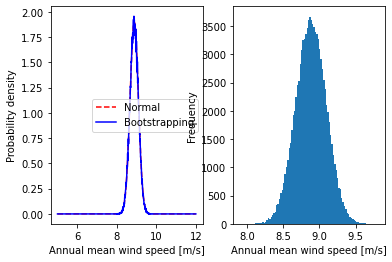

In [20]:
Ubins = np.linspace(5,12,1000)

pdf_N = stats.norm.pdf(Ubins,Umean,Ustd/np.sqrt(n))
dU = Ubins[1]-Ubins[0] # Scaling factor for the t-pdf to make sure we get a valid pdf for every bin spacing
pdf_T = (1/np.sqrt(dU))*stats.t.pdf((Ubins - Umean)/(Ustd/np.sqrt(n)), n - 1)

# Generating an empirical pdf from the bootstrap sample
BootstrapHist = np.histogram(BootstrapMeans,bins = Ubins)
BootstrapDist = stats.rv_histogram(BootstrapHist)
pdf_B = BootstrapDist.pdf(Ubins)

fig1, ax1 = plt.subplots(1,2)
p11 = ax1[0].plot(Ubins,pdf_N,'--r', label = 'Normal')
p12 = ax1[0].plot(Ubins,pdf_B,'-b', label = 'Bootstrapping')
# p13 = ax1[0].plot(Ubins,pdf_T,'-k', label = 'T-dist')
ax1[0].set_xlabel('Annual mean wind speed [m/s]')
ax1[0].set_ylabel('Probability density')
ax1[0].legend()

# p11 = ax1.plot(Ubins,pdf_N,'--r', label = 'Normal')
p22 = ax1[1].hist(BootstrapMeans, 100, label = 'Bootstrapping')
# # p13 = ax1.plot(Ubins,pdf_T,'-k', label = 'T-dist')
ax1[1].set_xlabel('Annual mean wind speed [m/s]')
ax1[1].set_ylabel('Frequency')
# plt.legend()

plt.show()

8.882995183574733
8.8848121871436
8.470070249985714 9.296400894932088
8.470973117983942 9.295017249165525
8.407446309087494 9.358544058061973


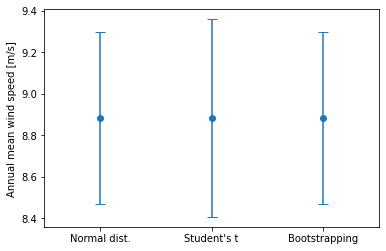

In [21]:
fig0, ax0 = plt.subplots()
print(Umean)
print(np.mean(BootstrapMeans))
print(CIn_B,CIp_B)
print(CIn_N,CIp_N)
print(CIn_T,CIp_T)

lower_error = [Umean-CIn_N, Umean-CIn_T, np.mean(BootstrapMeans)-CIn_B]
upper_error = [CIp_N-Umean, CIp_T-Umean, CIp_B-np.mean(BootstrapMeans)]

asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

ax0.errorbar([1, 2, 3], [Umean, Umean, np.mean(BootstrapMeans)],
             yerr = asymmetric_error,
            linestyle = '',marker = 'o',capsize = 5)
ax0.set_xlim([0.5,3.5])
ax0.set_xticks([1,2,3])
ax0.set_xticklabels(['Normal dist.','Student\'s t','Bootstrapping'])
ax0.set_ylabel('Annual mean wind speed [m/s]')
plt.show()

# Task 3 : Surrogate model

In [22]:
InputData = pd.read_excel(data_path + 'ML_ExampleDataSet.xlsx', 'InputVariables')
InputData = InputData.set_index('Sample_No', drop = False)
InputData.head()

,Sample_No,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi
Sample_No,,,,,,,
1,1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000
2,2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217
3,3,6.813467,2.261463,0.129071,88.379710,1.727273,-3.981593
4,4,14.500000,0.704260,0.332996,122.142857,2.090909,0.162810
5,5,5.356299,1.776301,1.147039,160.357143,2.454545,2.639008


In [23]:
TargetData = pd.read_excel(data_path + 'ML_ExampleDataSet.xlsx', 'LoadResults')
TargetData = TargetData.set_index('PointNo', drop = False)
TargetData.head()

,PointNo,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y
PointNo,,,,,,,,,
1,1,747.561872,200.666288,6708.717789,8861.885588,1229.076579,63.457528,4253.317748,15006.726860
2,2,3556.031457,676.339081,16692.647572,6329.099515,6952.985180,1354.995442,10409.290476,16289.414152
3,3,4667.540374,1337.390736,47357.937376,31829.036012,10138.140146,2804.304402,13755.148891,16535.154243
4,4,2468.757942,242.431345,8130.594535,3871.907737,4216.051060,250.684887,12307.312889,16500.098901
5,5,3261.845253,1035.420007,36971.924749,26395.063750,6630.640795,2256.349794,13128.763279,16207.306417


In [24]:
MergedData = pd.merge(InputData, TargetData, how='inner', on=[InputData['Sample_No'], TargetData['PointNo']])
MergedData

,key_0,key_1,Sample_No,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi,PointNo,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y
0,1,1,1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000,1,747.561872,200.666288,6708.717789,8861.885588,1229.076579,63.457528,4253.317748,15006.726860
1,2,2,2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217,2,3556.031457,676.339081,16692.647572,6329.099515,6952.985180,1354.995442,10409.290476,16289.414152
2,3,3,3,6.813467,2.261463,0.129071,88.379710,1.727273,-3.981593,3,4667.540374,1337.390736,47357.937376,31829.036012,10138.140146,2804.304402,13755.148891,16535.154243
3,4,4,4,14.500000,0.704260,0.332996,122.142857,2.090909,0.162810,4,2468.757942,242.431345,8130.594535,3871.907737,4216.051060,250.684887,12307.312889,16500.098901
4,5,5,5,5.356299,1.776301,1.147039,160.357143,2.454545,2.639008,5,3261.845253,1035.420007,36971.924749,26395.063750,6630.640795,2256.349794,13128.763279,16207.306417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,9996,9996,9996,15.991490,2.934493,-0.031461,271.543107,3.760740,14.080259,9996,6564.464434,858.778565,28091.651088,13608.101268,14513.682848,1147.107370,21518.552601,16773.394758
9976,9997,9997,9997,6.111425,0.948102,0.176589,8.454959,4.124377,41.866315,9997,2047.344061,385.287048,22144.619831,16663.888804,3024.747490,676.705869,3891.227781,15376.750042
9977,9998,9998,9998,13.326172,2.043617,0.345013,46.669245,4.488013,-6.197441,9998,5958.074303,646.040924,20715.173212,7395.479028,11789.005321,740.922800,19334.780023,17384.510924
9978,9999,9999,9999,9.298782,2.830030,0.709374,84.883531,4.851649,-4.457392,9999,6631.147297,1463.861197,42145.162750,21430.048990,15017.124218,3076.452821,24014.999552,18408.246843


In [25]:
%%timeit -n 10
AllInputData = InputData.where(InputData['Sample_No']==TargetData['PointNo'])
AllTargetData = TargetData.where(TargetData['PointNo']==InputData['Sample_No'])

3.63 ms ± 66.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
AllInputData = InputData.where(InputData['Sample_No']==TargetData['PointNo'])
AllTargetData = TargetData.where(TargetData['PointNo']==InputData['Sample_No'])
AllInputData.drop(columns = 'Sample_No', inplace = True)
AllTargetData.drop(columns = 'PointNo', inplace = True)
nsamples = AllInputData['U'].count() # Find the total number of data points in the data frame
FeatureNames = AllInputData.columns.values
DependentVariableNames = AllTargetData.columns.values
print('Feature names: ', FeatureNames)
print('Dependent variable names: ', DependentVariableNames)
print(AllInputData.iloc[:,0].values)
AllInputData

Feature names:  ['U' 'SigmaU' 'Alpha' 'MannL' 'MannGamma' 'VeerDeltaPhi']
Dependent variable names:  ['Tower_top_fore_aft_M_x' 'Tower_top_side2side_M_y'
 'Tower_base_fore_aft_M_x' 'Tower_base_side2side_M_y' 'Yaw_moment_M_z'
 'Main_shaft_torsion_M_z' 'Blade_root_flapwise_M_x'
 'Blade_root_edgewise_M_y']
[ 4.         10.1507576   6.81346652 ... 13.32617204  9.2987816
 19.89821019]


,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi
Sample_No,,,,,,
1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000
2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217
3,6.813467,2.261463,0.129071,88.379710,1.727273,-3.981593
4,14.500000,0.704260,0.332996,122.142857,2.090909,0.162810
5,5.356299,1.776301,1.147039,160.357143,2.454545,2.639008
...,...,...,...,...,...,...
9996,15.991490,2.934493,-0.031461,271.543107,3.760740,14.080259
9997,6.111425,0.948102,0.176589,8.454959,4.124377,41.866315
9998,13.326172,2.043617,0.345013,46.669245,4.488013,-6.197441


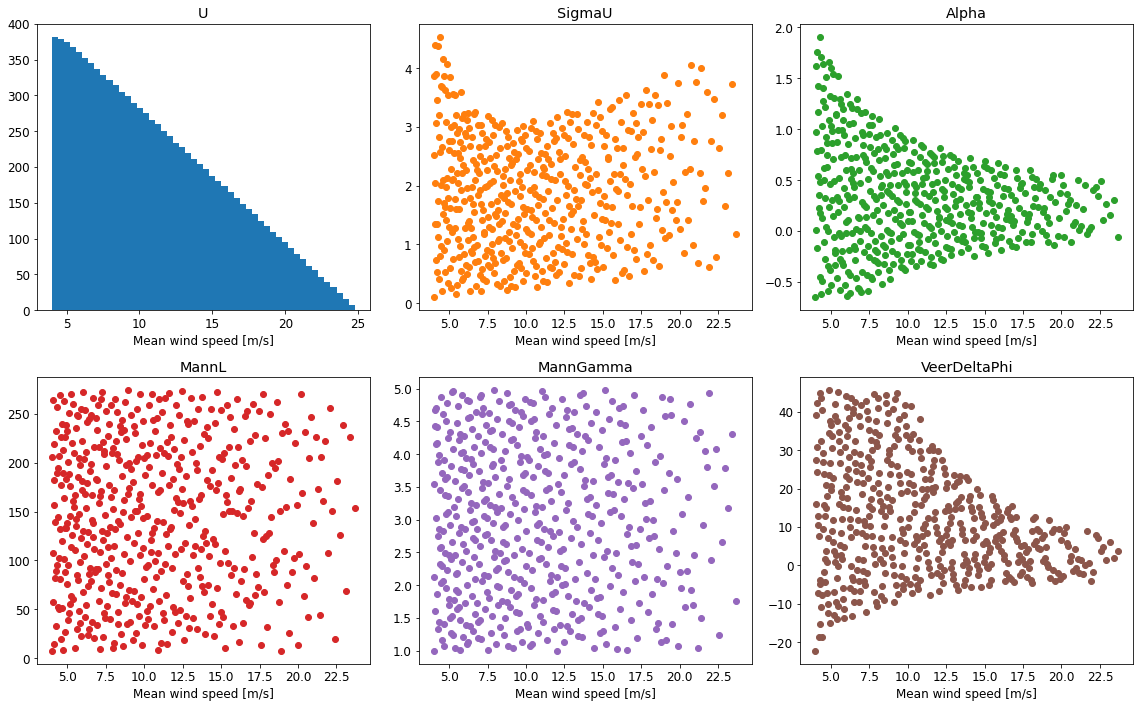

In [27]:
import matplotlib.pyplot as plt
nplotpoints = 500
plt.rc('font', size=12) 
fig1,axs1 = plt.subplots(2,3,figsize = (16,10))
plt.setp(axs1,xlabel = "Mean wind speed [m/s]")
plt.setp(axs1[0,0], title = FeatureNames[0])
plt.setp(axs1[0,1], title = FeatureNames[1])
plt.setp(axs1[0,2], title = FeatureNames[2])
plt.setp(axs1[1,0], title = FeatureNames[3])
plt.setp(axs1[1,1], title = FeatureNames[4])
plt.setp(axs1[1,2], title = FeatureNames[5])
axs1[0,0].hist(AllInputData.iloc[:,0],50,color = 'C0')
axs1[0,1].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,1],'o',color = 'C1')
axs1[0,2].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,2],'o',color = 'C2')
axs1[1,0].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,3],'o',color = 'C3')
axs1[1,1].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,4],'o',color = 'C4')
axs1[1,2].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,5],'o',color = 'C5')
plt.tight_layout()             
plt.show()

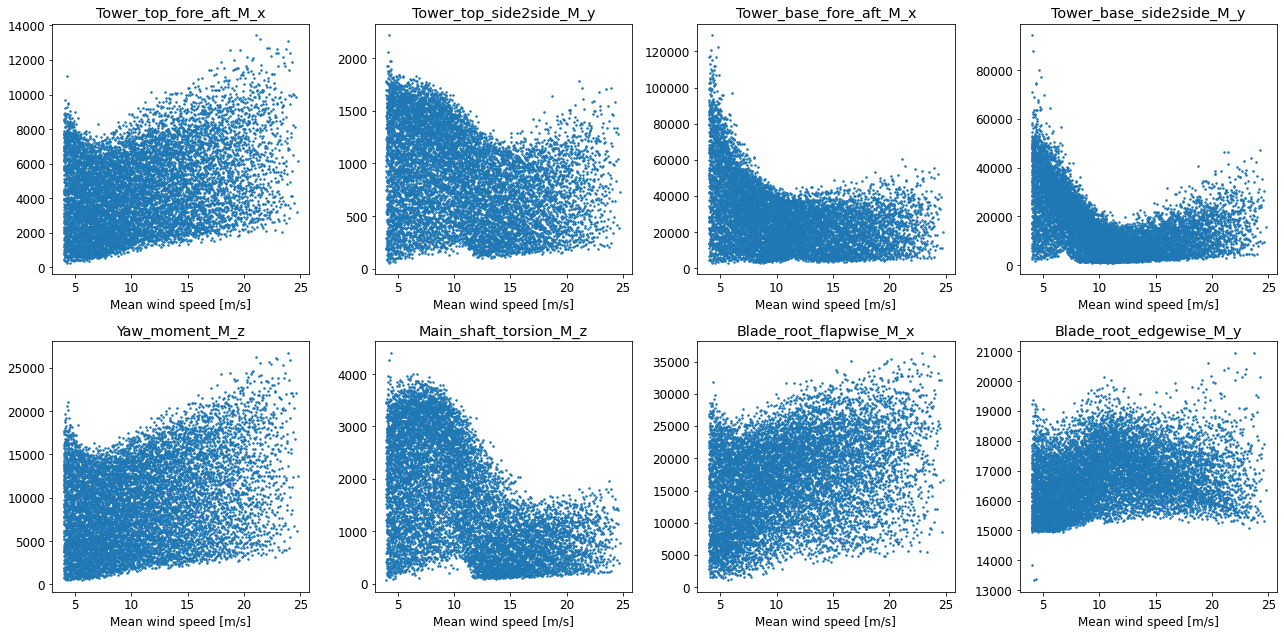

In [28]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.U,AllTargetData.iloc[:,idep],'.',markersize = 3)
    plt.xlabel('Mean wind speed [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
plt.show()

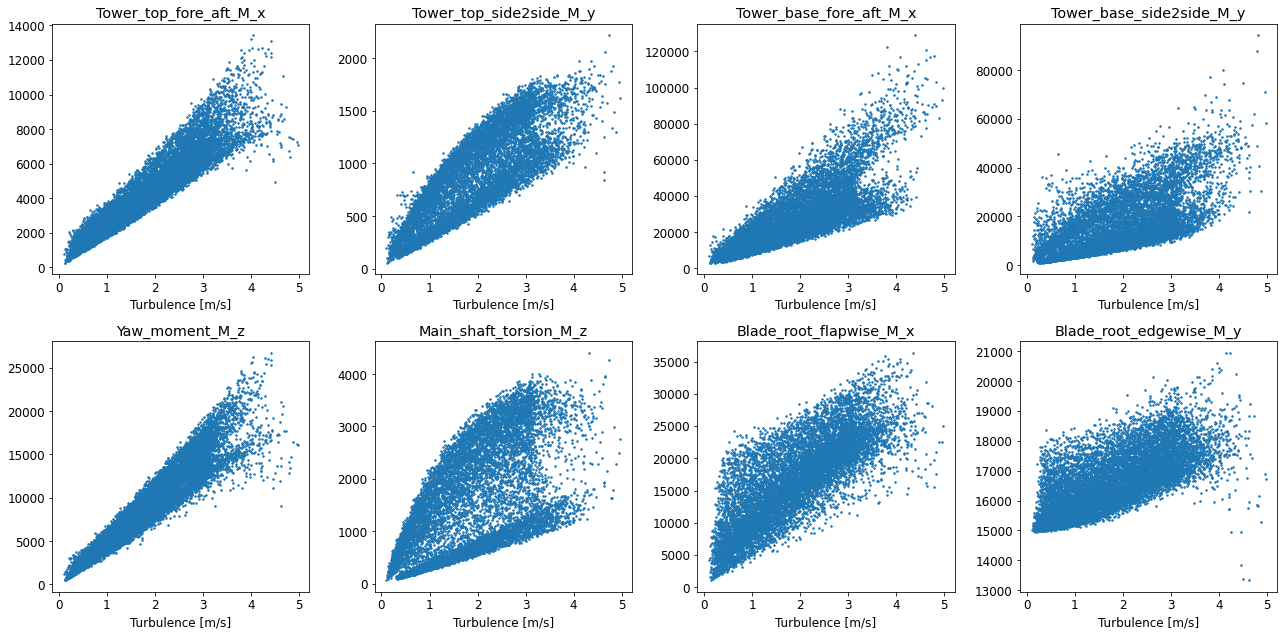

In [29]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.SigmaU,AllTargetData.iloc[:,idep],'.',markersize = 3)
    plt.xlabel('Turbulence [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
plt.show()

In [30]:
# Building a design matrix for a polynomial of 3rd order
def DesignMatrixO3(X):
    ndim = X.shape[1] 
    npoints = X.shape[0]
    m = int(((ndim-1)/2)*ndim)
    Xmatrix = np.zeros((npoints,3*ndim + 3*m + 1))
    columncount = 0
    Xmatrix[:,columncount] = np.ones(npoints)
    for i in range(ndim):
        columncount+=1
        Xmatrix[:,columncount] = X[:,i]

    for i in range(ndim -1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = X[:,i]*X[:,j]

    for i in range(ndim):
        columncount+= 1
        Xmatrix[:,columncount] = X[:,i]**2

    for i in range(ndim-1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = (X[:,i]**2)*X[:,j]

    for i in range(ndim-1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = X[:,i]*(X[:,j]**2)

    for i in range(ndim):
        columncount+=1
        Xmatrix[:,columncount] = X[:,i]**3
    return Xmatrix


def PredictPolyO3(X,Alsq):
    Xmatrix = DesignMatrixO3(X)
    Y = np.dot(Xmatrix,Alsq)
    return Y


def GetPredictedData(AllTargetData, Xmatrix):
    
    Y_Mx_pred = {}
    
    # print(AllTargetData.columns.values)
    for icol,col in enumerate(AllTargetData.columns.values):
    
        Y_Mx = AllTargetData['Tower_base_fore_aft_M_x']
        Y_Mx = AllTargetData[f'{col}']

        # Determine beta
        XX = np.dot(Xmatrix.T, Xmatrix)
        XY = np.dot(Xmatrix.T, Y_Mx)
        beta = np.linalg.lstsq(XX, XY, rcond=None)
        beta = beta[0]

        # Calculate predicted data and store      
        Y_Mx_pred[f'{col}'] = np.dot(Xmatrix, beta)
    
    # Create a dataframe with all the predicted data     
    AllPredData = pd.DataFrame(Y_Mx_pred)
    
    return AllPredData

In [31]:
# Construct coefficient matrix (Xmatrix)
Xmatrix = DesignMatrixO3(AllInputData.values)

AllPredData = GetPredictedData(AllTargetData, Xmatrix)

AllPredData.head()

,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y
0,308.229663,-97.191850,12395.122072,9826.745389,-7.673778,-503.436981,-2075.215108,6847.838849
1,3351.242486,430.366504,16781.487160,8831.420213,6542.993831,528.987474,8574.834871,13246.755104
2,4811.701415,1136.415676,39043.251690,22192.371567,10124.461251,2376.761863,14468.355150,15577.534358
3,2315.955317,202.659816,8179.088720,2427.873941,4224.764379,145.188651,12274.158123,16618.670883
4,3403.848701,1094.923977,33952.138176,23729.983452,7124.076714,2479.968797,14686.544669,16451.522627


### Dependence vs mean wind speed

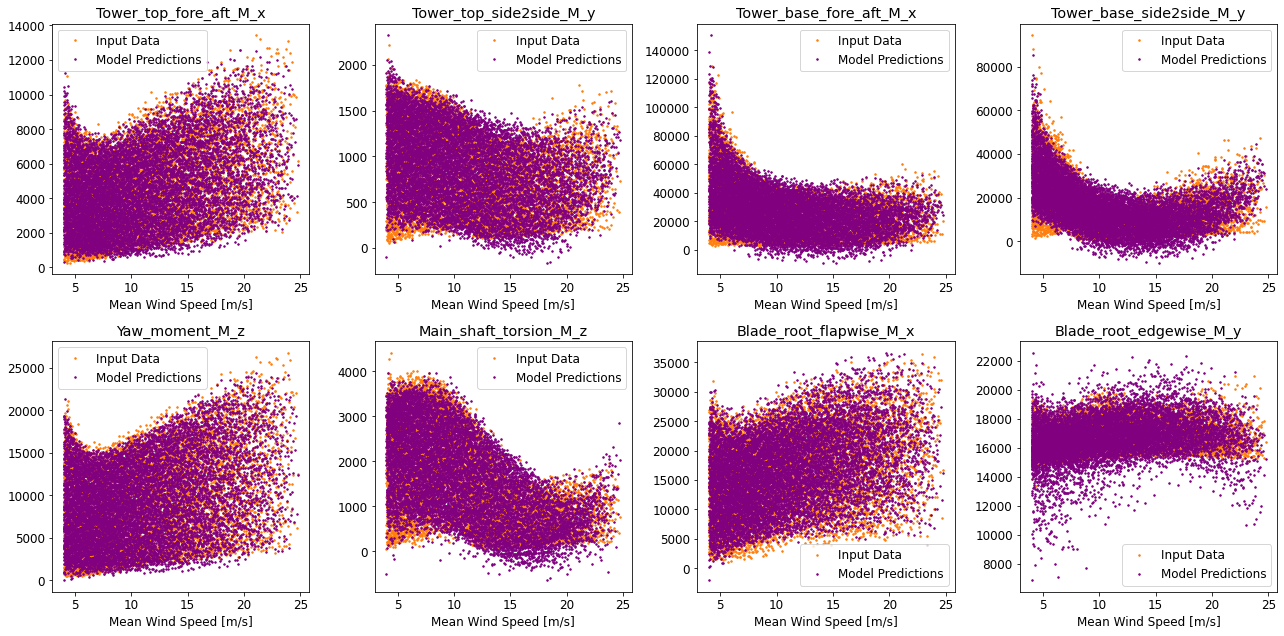

In [32]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.U,AllTargetData.iloc[:,idep],'.',markersize = 3, color = 'C1')
    plt.plot(AllInputData.U,AllPredData.iloc[:,idep],'.',markersize = 3, color = 'purple')
    plt.legend(['Input Data', 'Model Predictions'])
    plt.xlabel('Mean Wind Speed [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
# plt.savefig(results_path + 'task3/task3_MWS.pdf')
plt.show()
    

### Dependence vs Turbulence ($\sigma_U$)

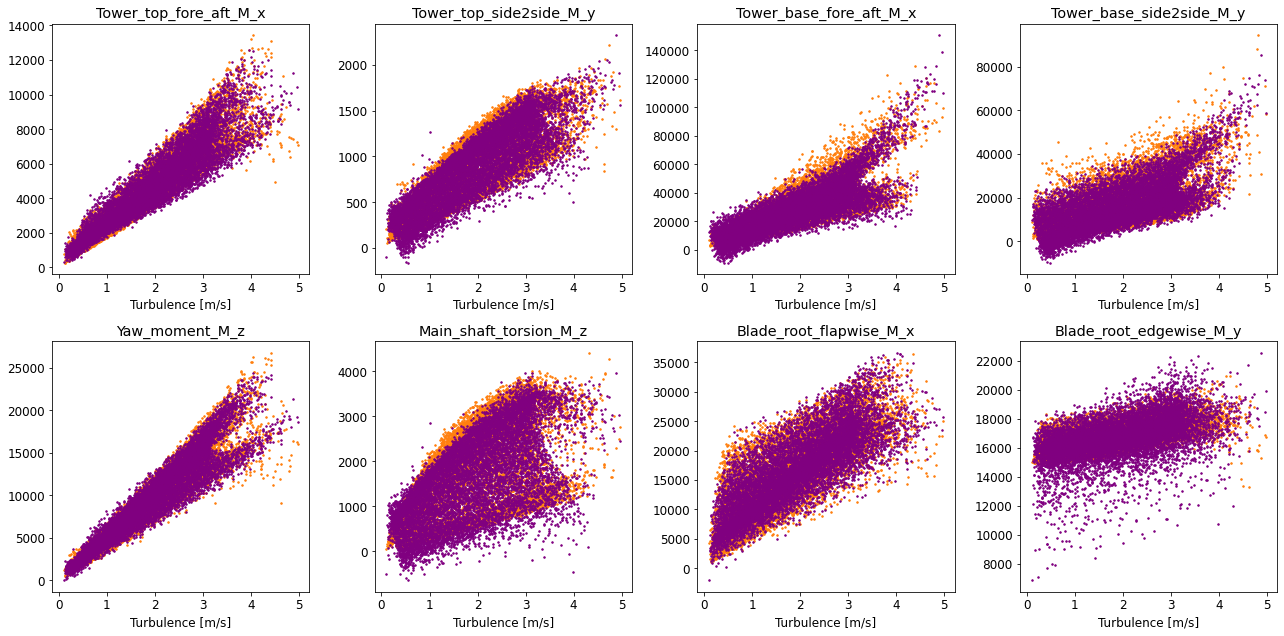

In [33]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.SigmaU,AllTargetData.iloc[:,idep],'.',markersize = 3, color = 'C1')
    plt.plot(AllInputData.SigmaU,AllPredData.iloc[:,idep],'.',markersize = 3, color = 'purple')
    plt.xlabel('Turbulence [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
# plt.savefig(results_path + 'task3/task3_SigmaU.pdf')
plt.show()

### Dependence vs shear exponent ($\alpha$)

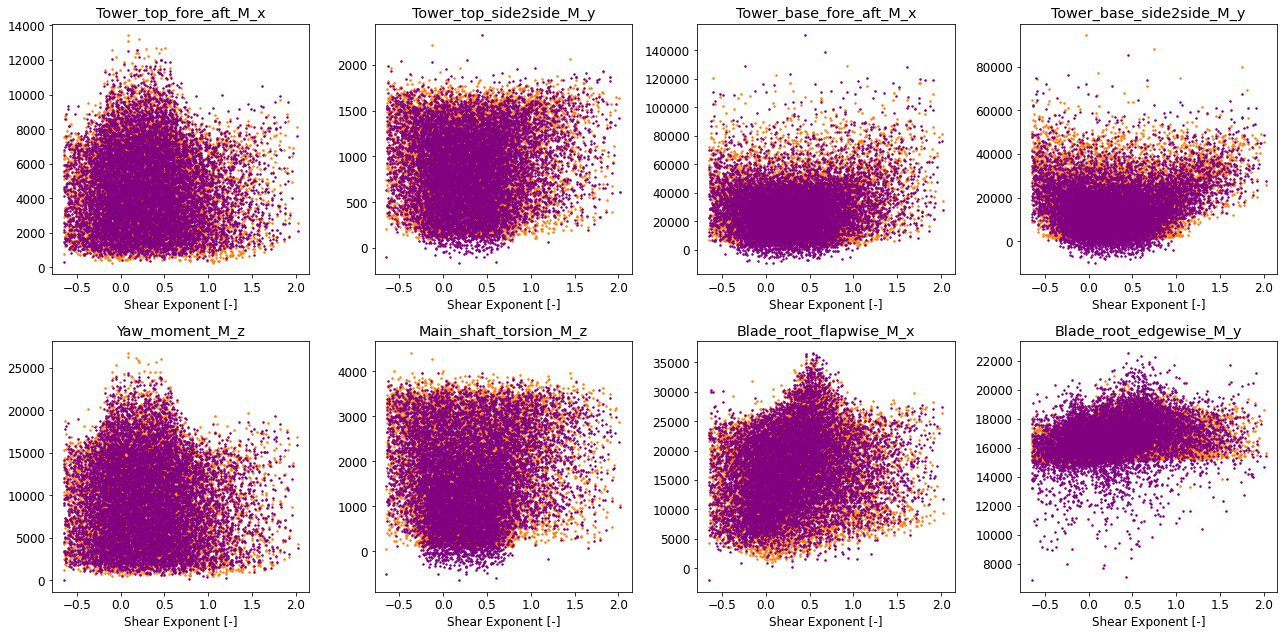

In [34]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.Alpha,AllTargetData.iloc[:,idep],'.',markersize = 3, color = 'C1')
    plt.plot(AllInputData.Alpha,AllPredData.iloc[:,idep],'.',markersize = 3, color = 'purple')
    plt.xlabel('Shear Exponent [-]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
# plt.savefig(results_path + 'task3/task3_Shearexp.pdf')
plt.show()

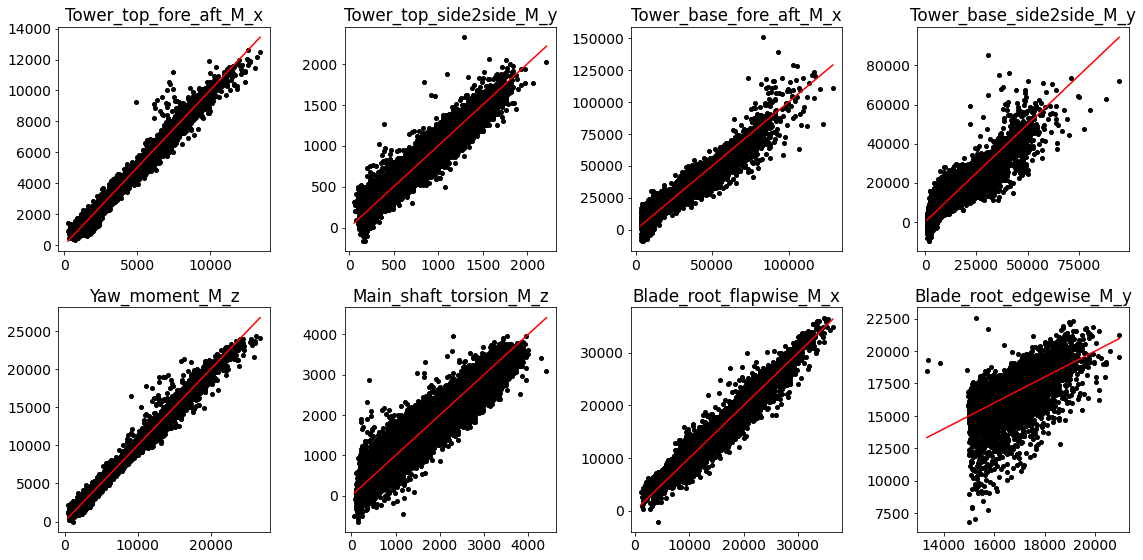

In [35]:
plt.rc('font', size=14) 
fig2a,axs2a = plt.subplots(2,4,figsize = (16,8))

for icol,col in enumerate(AllPredData):
    if icol <= 3:
        row=0
    else:
        row=1
        icol = icol-4
        
    axs2a[row,icol].plot(AllTargetData[f'{col}'],AllPredData[f'{col}'],'ok',markersize = 4)
    axs2a[row,icol].plot(np.array([np.min(AllTargetData[f'{col}']), np.max(AllTargetData[f'{col}'])]),\
         np.array([np.min(AllTargetData[f'{col}']), np.max(AllTargetData[f'{col}'])]),'-r')
    axs2a[row,icol].set_title(f"{col}")
    
# axs2a[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()       
# plt.savefig(results_path + 'task3/pp_comparison.png')
plt.show()

In [36]:
for icol,col in enumerate(AllPredData):
    
    Rsq_poly = (np.corrcoef(AllTargetData[f'{col}'],AllPredData[f'{col}'])[0,1])**2
    RMSE_poly = np.sqrt( np.mean((AllTargetData[f'{col}'] - AllPredData[f'{col}'])**2))
    print(f"\n{col}")
    print('R-square of polynomial model: ' + str(Rsq_poly))
    print('RMSE of polynomial model: ' + str(RMSE_poly))


Tower_top_fore_aft_M_x
R-square of polynomial model: 0.9780594696956738
RMSE of polynomial model: 3271.1287767859603

Tower_top_side2side_M_y
R-square of polynomial model: 0.9165201415106744
RMSE of polynomial model: 598.8295178881091

Tower_base_fore_aft_M_x
R-square of polynomial model: 0.9188387212394608
RMSE of polynomial model: 24848.188449527548

Tower_base_side2side_M_y
R-square of polynomial model: 0.832544739201432
RMSE of polynomial model: 15897.019890019483

Yaw_moment_M_z
R-square of polynomial model: 0.9840142868627316
RMSE of polynomial model: 6999.344281469442

Main_shaft_torsion_M_z
R-square of polynomial model: 0.8853027374091798
RMSE of polynomial model: 1374.5546415410138

Blade_root_flapwise_M_x
R-square of polynomial model: 0.9438148053469956
RMSE of polynomial model: 9413.046776504068

Blade_root_edgewise_M_y
R-square of polynomial model: 0.432777306119326
RMSE of polynomial model: 1787.0656009313443


In [37]:
# Obtaining the total blade root moment 
AllTargetData["Blade_root_tot"] = np.sqrt(AllTargetData["Blade_root_flapwise_M_x"]**2 + AllTargetData["Blade_root_edgewise_M_y"]**2)
AllTargetData

,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y,Blade_root_tot
PointNo,,,,,,,,,
1,747.561872,200.666288,6708.717789,8861.885588,1229.076579,63.457528,4253.317748,15006.726860,15597.838405
2,3556.031457,676.339081,16692.647572,6329.099515,6952.985180,1354.995442,10409.290476,16289.414152,19331.278841
3,4667.540374,1337.390736,47357.937376,31829.036012,10138.140146,2804.304402,13755.148891,16535.154243,21508.497085
4,2468.757942,242.431345,8130.594535,3871.907737,4216.051060,250.684887,12307.312889,16500.098901,20584.538234
5,3261.845253,1035.420007,36971.924749,26395.063750,6630.640795,2256.349794,13128.763279,16207.306417,20857.641442
...,...,...,...,...,...,...,...,...,...
9996,6564.464434,858.778565,28091.651088,13608.101268,14513.682848,1147.107370,21518.552601,16773.394758,27283.600895
9997,2047.344061,385.287048,22144.619831,16663.888804,3024.747490,676.705869,3891.227781,15376.750042,15861.465742
9998,5958.074303,646.040924,20715.173212,7395.479028,11789.005321,740.922800,19334.780023,17384.510924,26001.056491


### Fitting an neural network model

In [38]:
import sklearn
import sklearn.neural_network

In [39]:
# Initialise neural network model (regressor) object
ANNmodel = sklearn.neural_network.MLPRegressor()

ANNmodel.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [40]:
# Trying with tanh activation
ANNmodel.set_params(hidden_layer_sizes=(12,12), activation='tanh', verbose = True )
ANNmodel.fit(AllInputData.values, AllTargetData["Blade_root_tot"])

Iteration 1, loss = 301988070.08700389
Iteration 2, loss = 301950406.13181800
Iteration 3, loss = 301923622.68485337
Iteration 4, loss = 301900338.60844016
Iteration 5, loss = 301879719.76487660
Iteration 6, loss = 301860609.38456202
Iteration 7, loss = 301842354.75612527
Iteration 8, loss = 301824680.70543027
Iteration 9, loss = 301807375.56661475
Iteration 10, loss = 301790343.13735288
Iteration 11, loss = 301773515.77026749
Iteration 12, loss = 301756848.53389156
Iteration 13, loss = 301740307.39898700
Iteration 14, loss = 301723872.24817854
Iteration 15, loss = 301707520.50650364
Iteration 16, loss = 301691254.94150436
Iteration 17, loss = 301675042.60718715
Iteration 18, loss = 301658892.30880839
Iteration 19, loss = 301642790.38269365
Iteration 20, loss = 301626722.67474955
Iteration 21, loss = 301610693.44671226
Iteration 22, loss = 301594694.23069090
Iteration 23, loss = 301578732.39243764
Iteration 24, loss = 301562794.31432658
Iteration 25, loss = 301546880.11188650
Iteration

C:\Users\Ioannis Prsk\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='tanh', hidden_layer_sizes=(12, 12), verbose=True)

In [41]:
ANNmodel.score(AllInputData, AllTargetData["Blade_root_tot"])

C:\Users\Ioannis Prsk\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


-22.16041712622892

In [42]:
# Trying with relu activation
ANNmodel.set_params(activation='relu')
ANNmodel.fit(AllInputData.values, AllTargetData["Blade_root_tot"])
print('Model r-square with full data set: ' + str(ANNmodel.score(AllInputData,AllTargetData['Blade_root_tot'])))

Iteration 1, loss = 301663909.34790963
Iteration 2, loss = 299695738.67479455
Iteration 3, loss = 296741572.22760117
Iteration 4, loss = 292344370.12383252
Iteration 5, loss = 285117894.44440573
Iteration 6, loss = 273398913.65593898
Iteration 7, loss = 255908303.84163523
Iteration 8, loss = 234013975.77975878
Iteration 9, loss = 208517248.84826067
Iteration 10, loss = 180871129.95572159
Iteration 11, loss = 152842564.41060686
Iteration 12, loss = 126518328.89340979
Iteration 13, loss = 103778309.67769910
Iteration 14, loss = 85889231.82361314
Iteration 15, loss = 73195517.75296161
Iteration 16, loss = 65163761.12554210
Iteration 17, loss = 60639737.75730994
Iteration 18, loss = 58273162.04590562
Iteration 19, loss = 57113073.47308321
Iteration 20, loss = 56472445.20475034
Iteration 21, loss = 56048266.57540356
Iteration 22, loss = 55692594.80842942
Iteration 23, loss = 55354438.26743898
Iteration 24, loss = 55017253.22928120
Iteration 25, loss = 54679009.91142621
Iteration 26, loss = 

C:\Users\Ioannis Prsk\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Ioannis Prsk\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [43]:
# None of the two activation methods has given converged fit

In [44]:
Xscaler = sklearn.preprocessing.StandardScaler()
Yscaler = sklearn.preprocessing.StandardScaler()
Xscaler = Xscaler.fit(AllInputData)
Yscaler = Yscaler.fit(AllTargetData["Blade_root_tot"].values.reshape(-1,1))


TrainTestRatio = 0.8
N = len(AllInputData)
print(AllInputData.shape)

# Here we take only a subset of the input data, not the entire dataset
Xtrain = Xscaler.transform(AllInputData.values[:int(N*TrainTestRatio),:])
Xtest = Xscaler.transform(AllInputData.values[int(N*TrainTestRatio):,:])

Ytrain = Yscaler.transform(AllTargetData['Blade_root_tot'].values[:int(N*TrainTestRatio)].reshape(-1,1))
Ytest = Yscaler.transform(AllTargetData['Blade_root_tot'].values[int(N*TrainTestRatio):].reshape(-1,1))

print(AllTargetData)
print(AllInputData.values)
print(AllInputData.values[:int(N*TrainTestRatio),:])
print(N*TrainTestRatio)
print(Ytrain)

(9980, 6)
         Tower_top_fore_aft_M_x  Tower_top_side2side_M_y  \
PointNo                                                    
1                    747.561872               200.666288   
2                   3556.031457               676.339081   
3                   4667.540374              1337.390736   
4                   2468.757942               242.431345   
5                   3261.845253              1035.420007   
...                         ...                      ...   
9996                6564.464434               858.778565   
9997                2047.344061               385.287048   
9998                5958.074303               646.040924   
9999                6631.147297              1463.861197   
10000               2496.414854               257.615064   

         Tower_base_fore_aft_M_x  Tower_base_side2side_M_y  Yaw_moment_M_z  \
PointNo                                                                      
1                    6708.717789               8861.8

C:\Users\Ioannis Prsk\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ioannis Prsk\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [45]:
Ytrain.shape

(7984, 1)

In [46]:
# Make a fit with the transformed data

ANNmodel.set_params(learning_rate_init = 0.01, activation = 'relu',tol = 1e-6,n_iter_no_change = 10, hidden_layer_sizes = (12,12), validation_fraction = 0.1)

ANNmodel.fit(Xtrain, Ytrain.ravel())


Iteration 1, loss = 0.21371112
Iteration 2, loss = 0.04863910
Iteration 3, loss = 0.02644256
Iteration 4, loss = 0.02216522
Iteration 5, loss = 0.01827136
Iteration 6, loss = 0.01549102
Iteration 7, loss = 0.01355568
Iteration 8, loss = 0.01230862
Iteration 9, loss = 0.01128393
Iteration 10, loss = 0.01076339
Iteration 11, loss = 0.00988149
Iteration 12, loss = 0.00940953
Iteration 13, loss = 0.00935933
Iteration 14, loss = 0.00909666
Iteration 15, loss = 0.00994274
Iteration 16, loss = 0.00859300
Iteration 17, loss = 0.00858845
Iteration 18, loss = 0.00864895
Iteration 19, loss = 0.00816978
Iteration 20, loss = 0.00816820
Iteration 21, loss = 0.00804710
Iteration 22, loss = 0.00813471
Iteration 23, loss = 0.00817216
Iteration 24, loss = 0.00779542
Iteration 25, loss = 0.00765453
Iteration 26, loss = 0.00768281
Iteration 27, loss = 0.00744669
Iteration 28, loss = 0.00743516
Iteration 29, loss = 0.00792503
Iteration 30, loss = 0.00873355
Iteration 31, loss = 0.00785960
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(12, 12), learning_rate_init=0.01, tol=1e-06,
             verbose=True)

In [47]:
print( 'Train set r-square: ' + str(ANNmodel.score(Xtrain,Ytrain)))
print( 'Test set r-square: ' + str(ANNmodel.score(Xtest,Ytest)))

Train set r-square: 0.9865420410822135
Test set r-square: 0.9857898318085093


In [48]:
# Compute model predictions for test data
Yout = Yscaler.inverse_transform(ANNmodel.predict(Xtrain).reshape(-1,1))
Yout_test = Yscaler.inverse_transform(ANNmodel.predict(Xtest).reshape(-1,1))

In [49]:
Yout_test.shape

(1996, 1)

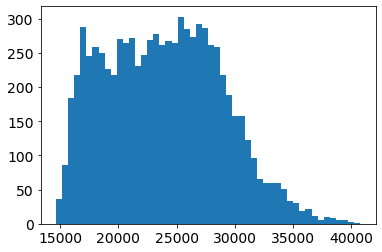

In [50]:
plt.hist(Yout,50)
plt.show()

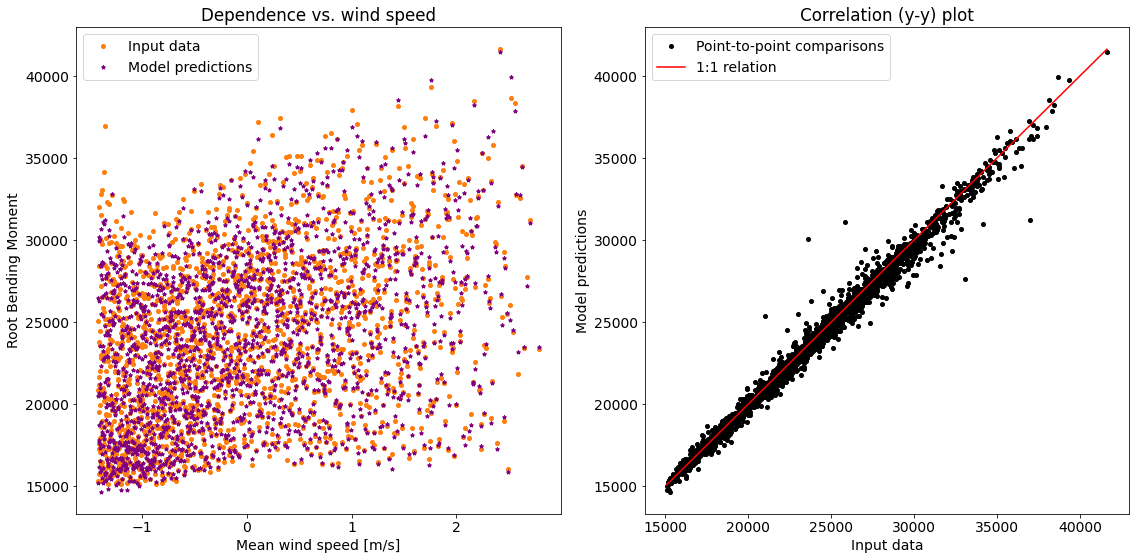

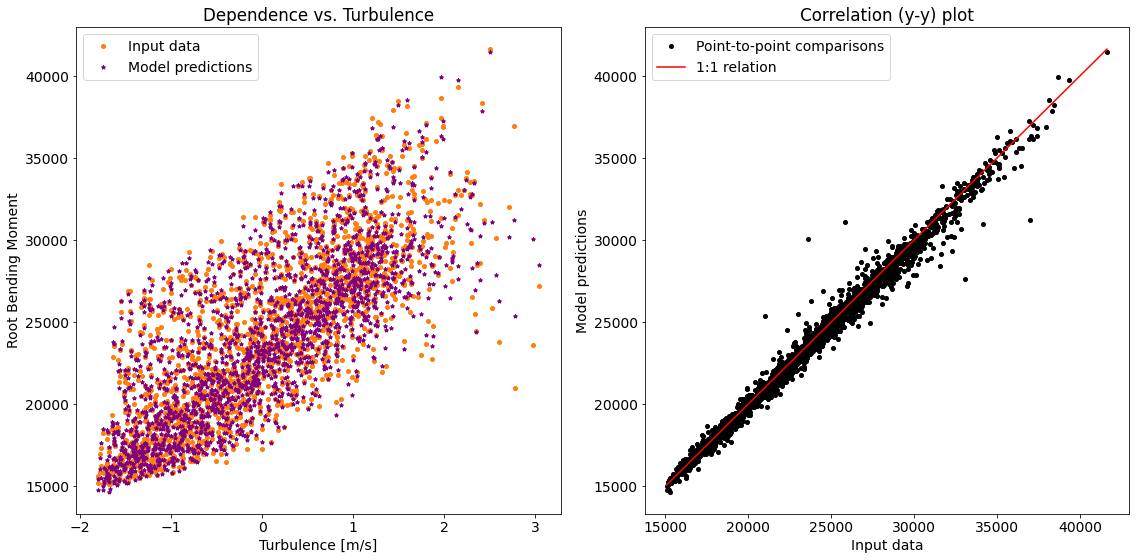

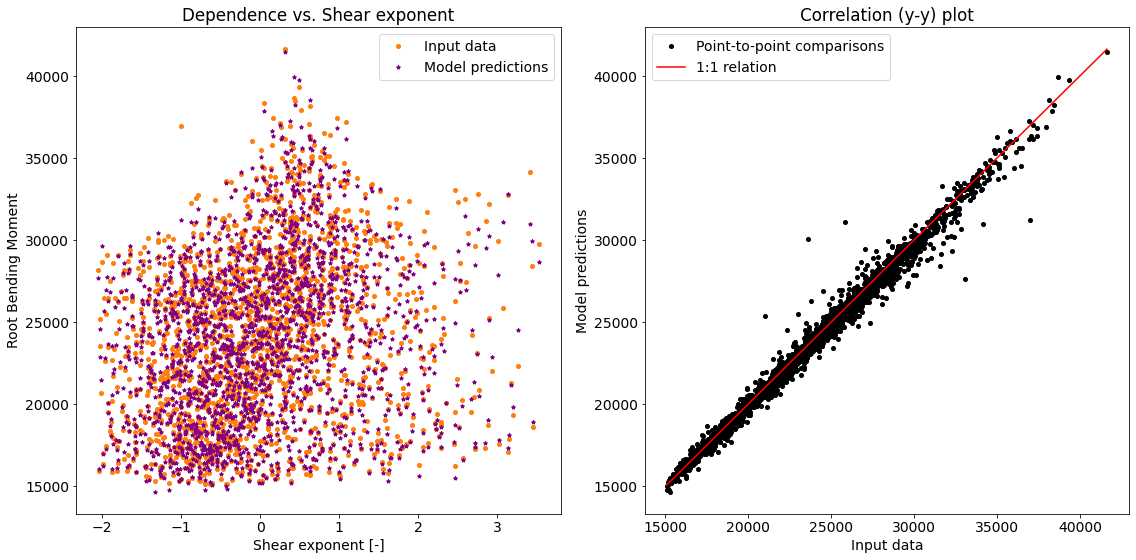

In [51]:
import numpy as np
plt.rc('font', size=14) 
fig3,axs3 = plt.subplots(1,2,figsize = (16,8))
plt.setp(axs3[0], title = 'Dependence vs. wind speed', xlabel = 'Mean wind speed [m/s]',ylabel = 'Root Bending Moment')
plt.setp(axs3[1], title = 'Correlation (y-y) plot', xlabel = 'Input data',ylabel = 'Model predictions')
axs3[0].plot(Xtest[:,0],Yscaler.inverse_transform(Ytest),'o',markersize = 4,color = 'C1')
axs3[0].plot(Xtest[:,0],Yout_test,'*',markersize = 4,color = 'purple')
axs3[0].legend(['Input data','Model predictions'])
axs3[1].plot(Yscaler.inverse_transform(Ytest),Yout_test,'ok',markersize = 4)
axs3[1].plot(np.array([np.min(AllTargetData['Blade_root_tot']), np.max(AllTargetData['Blade_root_tot'])]),\
             np.array([np.min(AllTargetData['Blade_root_tot']), np.max(AllTargetData['Blade_root_tot'])]),'-r')
axs3[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()             
plt.show()


plt.rc('font', size=14) 
fig3,axs3 = plt.subplots(1,2,figsize = (16,8))
plt.setp(axs3[0], title = 'Dependence vs. Turbulence', xlabel = 'Turbulence [m/s]',ylabel = 'Root Bending Moment')
plt.setp(axs3[1], title = 'Correlation (y-y) plot', xlabel = 'Input data',ylabel = 'Model predictions')
axs3[0].plot(Xtest[:,1],Yscaler.inverse_transform(Ytest),'o',markersize = 4,color = 'C1')
axs3[0].plot(Xtest[:,1],Yout_test,'*',markersize = 4,color = 'purple')
axs3[0].legend(['Input data','Model predictions'])
axs3[1].plot(Yscaler.inverse_transform(Ytest),Yout_test,'ok',markersize = 4)
axs3[1].plot(np.array([np.min(AllTargetData['Blade_root_tot']), np.max(AllTargetData['Blade_root_tot'])]),\
             np.array([np.min(AllTargetData['Blade_root_tot']), np.max(AllTargetData['Blade_root_tot'])]),'-r')
axs3[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()             
plt.show()

plt.rc('font', size=14) 
fig3,axs3 = plt.subplots(1,2,figsize = (16,8))
plt.setp(axs3[0], title = 'Dependence vs. Shear exponent', xlabel = 'Shear exponent [-]',ylabel = 'Root Bending Moment')
plt.setp(axs3[1], title = 'Correlation (y-y) plot', xlabel = 'Input data',ylabel = 'Model predictions')
axs3[0].plot(Xtest[:,2],Yscaler.inverse_transform(Ytest),'o',markersize = 4,color = 'C1')
axs3[0].plot(Xtest[:,2],Yout_test,'*',markersize = 4,color = 'purple')
axs3[0].legend(['Input data','Model predictions'])
axs3[1].plot(Yscaler.inverse_transform(Ytest),Yout_test,'ok',markersize = 4)
axs3[1].plot(np.array([np.min(AllTargetData['Blade_root_tot']), np.max(AllTargetData['Blade_root_tot'])]),\
             np.array([np.min(AllTargetData['Blade_root_tot']), np.max(AllTargetData['Blade_root_tot'])]),'-r')
axs3[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()             
plt.show()

# Task 4

In [53]:
m = 3
k = 4*10**12

N_MC = 10**4-10**5
Delta = np.random.lognormal(mean=1, sigma=0.3, size=N_MC)
XM = np.random.normal(loc=1, scale=0.2, size=N_MC)
XW = np.random.normal(loc=1, scale= ... , size=N_MC)

N_st = 100-200
U = stats.weibull_min.pdf...
SigmaU = f(U)
alpha = stats.truncnorm.pdf()
input_data = pd.DataFrame({'U': , 'SigmaU' : , 'Alpha' : alpha})


In [80]:
## Example on how to use the regressor model 
# specially dedicated to Modestakos Athanasiou or Modecat8

# Step1 : Creating a dummy dataframe: 
# Note that the number of inputs should agree with the number 
# of AllInputData (as the model has been trained based on that dataset)
# In that case 6 (U, SigmaU, Alpha, MannL, MannGamma, VeerDeltaPhi)
input_data = pd.DataFrame({'U': range(10), 
                           'SigmaU': range(10),
                           'Alpha' : range(10),
                           'MannL' : range(10),  
                           'MannGamma' : range(10), 
                           'VeerDeltaPhi': range(10)
                          })

# Step2 : Computing predicted data (Watch out : the output data is scaled)
pred = ANNmodel.predict(input_data)

# Step3 : So scale the predicted data to obtain the original predictions
original_predictions = Yscaler.inverse_transform(pred.reshape(-1, 1))

# Step4 : Listen to Karvelas' songs

C:\Users\Ioannis Prsk\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [81]:
original_predictions

array([[ 24832.2768012 ],
       [ 36836.15524737],
       [ 52775.72992239],
       [ 68308.43414695],
       [ 83998.59978818],
       [ 99091.68298286],
       [114184.76617755],
       [129277.84937223],
       [144370.93256692],
       [159464.0157616 ]])

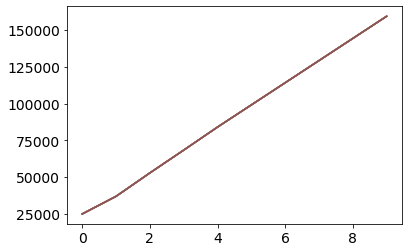

In [82]:
plt.plot(input_data, original_predictions)